In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

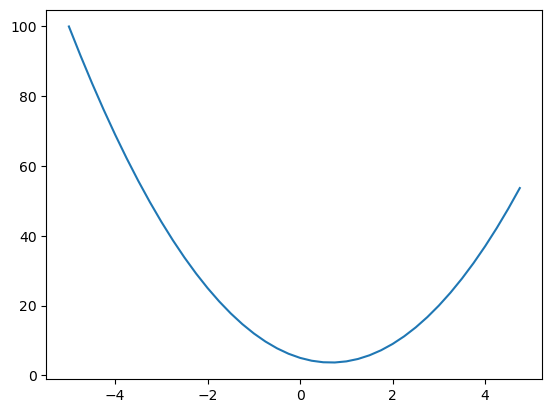

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.0000001
x = 2/3
(f(x+h) - f(x))/h

2.9753977059954195e-07

In [6]:
# different der. example
a = 2.0 
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [7]:
h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [8]:
# from micrograd repo

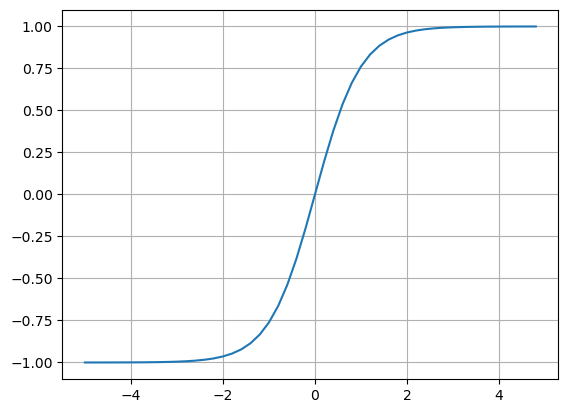

In [9]:
# mathematical modeling of a neuron
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [10]:
#export 
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        # children helps us keep track of previous nodes 
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other
    
    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)
        
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += (other.data * out.grad)
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        def _backward():
            self.grad+= other * self.data**(other-1) * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1
    
    def tanh(self):
        n = self.data
        t = (math.exp(2*n)-1)/(math.exp(2*n)+1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1-t**2) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        # topo sort the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [11]:
# Small example of mathematical neuron
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
z = a*b; z.label = 'z'
d = z + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f
L

Value(data=-8.0)

In [12]:
from graphviz import Digraph


# Taken directly from Andrej Karpathy's NN ZtoH video series 

def trace(root):
    # this builds a set of nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) 
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a 'record' node for it 
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value was from an operation, create op node for it
            dot.node(name = uid + n._op, label = n._op)
            # connect this node to said op node
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


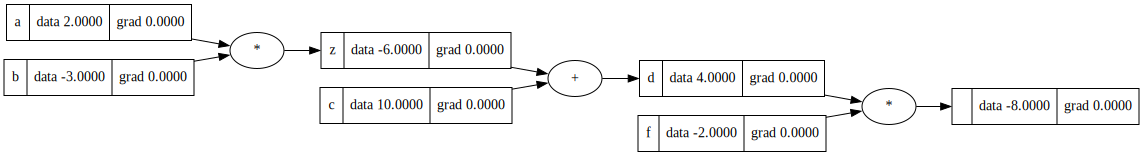

In [13]:
draw_dot(L)

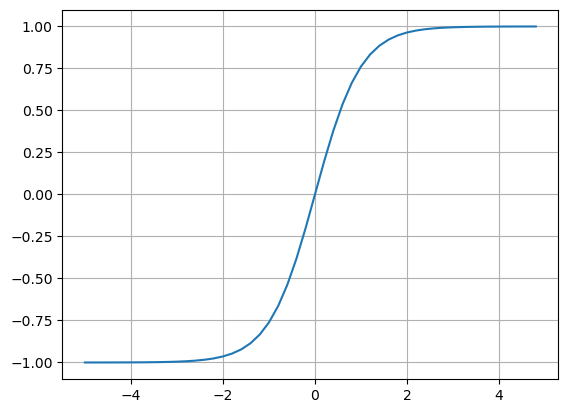

In [14]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [15]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.881373580195, label='b')
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1+x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----------
#o = n.tanh(); o.label='o'|
e = (2*n).exp()
o = (e-1) / (e+1)
# ----------


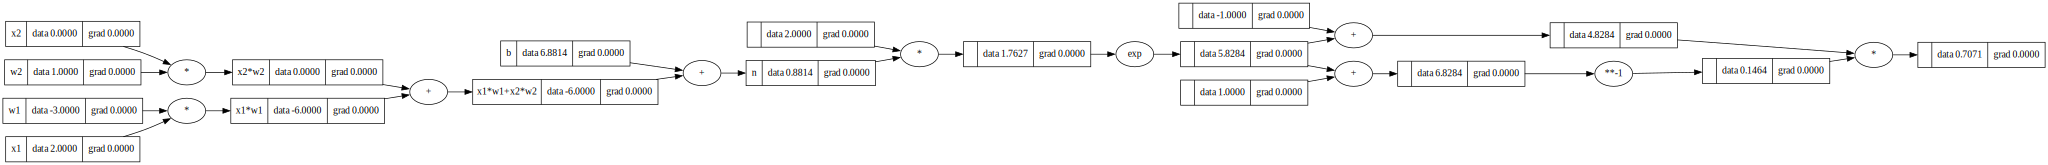

In [16]:
draw_dot(o)

In [17]:
o.grad = 1.0
o.backward()

In [18]:
# now working in PyTorch
import torch
import random

In [19]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.881373580195]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [26]:
#export 
class Neuron:
    # nin: number of inputs to neuron
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # zip take two iterators, and creates tuple with a new iterator over top
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    #nin: num of inputs
    #nout: num of outputs
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
    # nin: num of inputs
    # nouts: list of neurons per layer
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [27]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.740671554270415)

In [28]:
len(n.parameters())

41

In [29]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets


In [30]:
for k in range(20):
    # forward pass (filling in data forward-wise)
    ypred = [n(x) for x in xs]
    loss = sum([(yout-ygt)**2 for ygt, yout in zip(ys, ypred)])

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)
    

0 4.821194476412115
1 3.0617147341492763
2 2.063325186583721
3 1.2450342600820592
4 0.7123431879648511
5 0.4482612685504726
6 0.31650453655533173
7 0.24230750597231734
8 0.19576009652202492
9 0.164111071897852
10 0.1412739148524637
11 0.12404110932492926
12 0.11058042524661074
13 0.09977525481811053
14 0.09090851385144418
15 0.08349947690606441
16 0.07721414894307026
17 0.0718133882220615
18 0.06712151770554507
19 0.0630065976670734


In [31]:
ypred

[Value(data=0.9027606098751921),
 Value(data=-0.8652331465672245),
 Value(data=-0.8552082166605683),
 Value(data=0.8798986537608978)]